In [47]:
import numpy as np 
import pandas as pd  
import warnings 
warnings.filterwarnings('ignore') 

In [48]:
data=pd.read_csv('MRTSSM451211USN.csv') 

In [49]:
from datetime import datetime,timedelta 

In [50]:
data.columns=["Month","Sales"] 

In [51]:
data['Month']=pd.to_datetime(data['Month'],infer_datetime_format=True) 
data.set_index('Month',inplace=True) 

In [52]:
data.head(15)  

,Sales
Month,
1992-01-01,790
1992-01-02,539
1992-01-03,535
1992-01-04,523
1992-01-05,552
1992-01-06,589
1992-01-07,592
1992-01-08,894
1992-01-09,861


In [53]:
data.tail(15) 

,Sales
Month,
2018-01-08,1368
2018-01-09,976
2018-01-10,722
2018-01-11,752
2018-01-12,1270
2019-01-01,1136
2019-01-02,644
2019-01-03,664
2019-01-04,713


In [54]:
### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller 

In [55]:
test_result=adfuller(data['Sales']) 

In [56]:
#Ho: It is non stationary 
#H1: It is stationary 

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [57]:
adfuller_test(data['Sales'])

ADF Test Statistic : -1.2305707169727274
p-value : 0.6603086862726568
#Lags Used : 16
Number of Observations Used : 317
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [58]:
data['Sales First Difference'] = data['Sales'] - data['Sales'].shift(1)

In [59]:
data['Sales'].shift(1)

Month
1992-01-01       NaN
1992-01-02     790.0
1992-01-03     539.0
1992-01-04     535.0
1992-01-05     523.0
               ...  
2019-01-06     763.0
2019-01-07     672.0
2019-01-08     646.0
2019-01-09    1226.0
2019-01-10     952.0
Name: Sales, Length: 334, dtype: float64

In [60]:
data['Seasonal First Difference']=data['Sales']-data['Sales'].shift(12)

In [61]:
data.head(14)

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1992-01-01,790,NaN,NaN
1992-01-02,539,-251.0,NaN
1992-01-03,535,-4.0,NaN
1992-01-04,523,-12.0,NaN
1992-01-05,552,29.0,NaN
1992-01-06,589,37.0,NaN
1992-01-07,592,3.0,NaN
1992-01-08,894,302.0,NaN
1992-01-09,861,-33.0,NaN


In [62]:
adfuller_test(data['Seasonal First Difference'].dropna()) 

ADF Test Statistic : -3.458336897549525
p-value : 0.00912382344944219
#Lags Used : 4
Number of Observations Used : 317
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

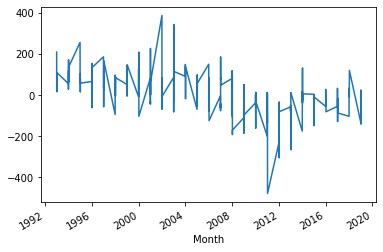

In [63]:
data['Seasonal First Difference'].plot() 

In [64]:
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
import statsmodels.api as sm 
import matplotlib.pyplot as plt 

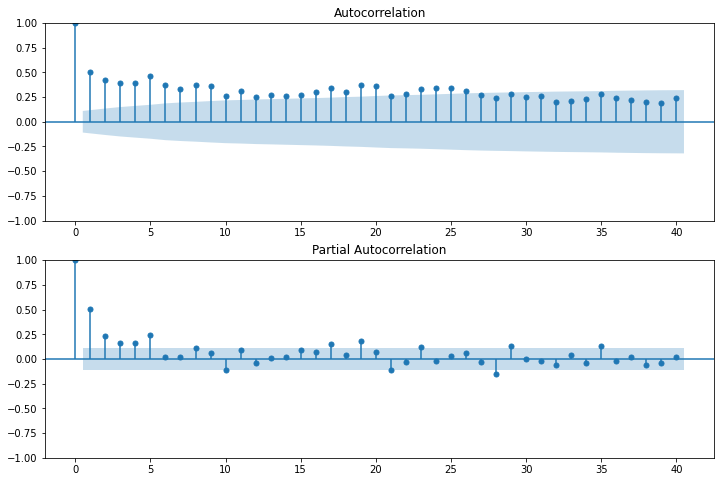

In [65]:
fig = plt.figure(figsize=(12,8)) 
ax1 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_acf(data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1) 
ax2 = fig.add_subplot(212) 
fig = sm.graphics.tsa.plot_pacf(data['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2) 

In [66]:
import itertools 
p = d = q = range(0, 2) 
pdq = list(itertools.product(p, d, q)) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 
print('Examples of parameter combinations for Seasonal ARIMA...') 
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1])) 
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2])) 
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3])) 
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4])) 

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [67]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)

            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5659.228115156593
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5065.255999089926
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3810.1334941885866
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3663.866247011736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3828.169340213126
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3800.9769804810758
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3666.905260426951
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3616.846603889741
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5313.568363609427
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4748.4339096823915
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3741.5688832357146
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3607.186086022743
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3770.587509036859
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3741.827938764036
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3627.502741900062
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3579.710000674672
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:5010.722179677357
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:4479.125745165011
ARIMA(

In [68]:
y=data['Sales'] 

In [81]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit() 


In [70]:
results

In [71]:
import pickle
# Save the trained model to a pickle file
with open('my_model.pkl', 'wb') as f: 
    pickle.dump(results, f)


In [72]:
# Load the pickle file
with open('my_model.pkl', 'rb') as f: 
    my_model = pickle.load(f)

In [73]:
y 

Month
1992-01-01     790
1992-01-02     539
1992-01-03     535
1992-01-04     523
1992-01-05     552
              ... 
2019-01-06     672
2019-01-07     646
2019-01-08    1226
2019-01-09     952
2019-01-10     710
Name: Sales, Length: 334, dtype: int64

In [74]:
type(y) 

pandas.core.series.Series

In [75]:
pred = my_model.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False) 
pred_ci = pred.conf_int() 


In [76]:
pred 

In [77]:
y_forecasted = pred.predicted_mean 
y_truth = data['Sales'] 
mse = ((y_forecasted - y_truth) ** 2).mean() 
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2))) 

The Mean Squared Error of our forecasts is 5047.4


In [78]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2))) 

The Root Mean Squared Error of our forecasts is 71.05


In [79]:
n=int(input("enter the no of months : ")) 

enter the no of months : 5


In [80]:
pred_uc = my_model.get_forecast(steps=n) 
pred_ci = pred_uc.conf_int() 

In [35]:
print(pred_uc) 

In [36]:
pred__mean=(pred_ci['lower Sales']+pred_ci['upper Sales'])/2 

In [37]:
check=np.ceil(pred__mean) 

In [38]:
type(pred__mean) 

pandas.core.series.Series

In [39]:
data = np.array(pred__mean) 

In [40]:
forecast=list(data) 

In [41]:
print(forecast) 

[721.804814929874, 1230.7837687893202, 1129.3170620764024, 625.7623328426579, 646.5369012070996]


In [42]:
forecast_index = pd.date_range(start='2020-01-01',periods=n,freq='MS') 

In [43]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast']) 

In [44]:
print(type(forecast_df)) 

<class 'pandas.core.frame.DataFrame'>


In [45]:
forecast_df

,Forecast
2020-01-01,721.804815
2020-02-01,1230.783769
2020-03-01,1129.317062
2020-04-01,625.762333
2020-05-01,646.536901


In [46]:
data

array([ 721.80481493, 1230.78376879, 1129.31706208,  625.76233284,
        646.53690121])